# 1. Prepare Data

In [1]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

In [2]:
digits = load_digits()
X = digits.data
y = digits.target

In [3]:
X

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

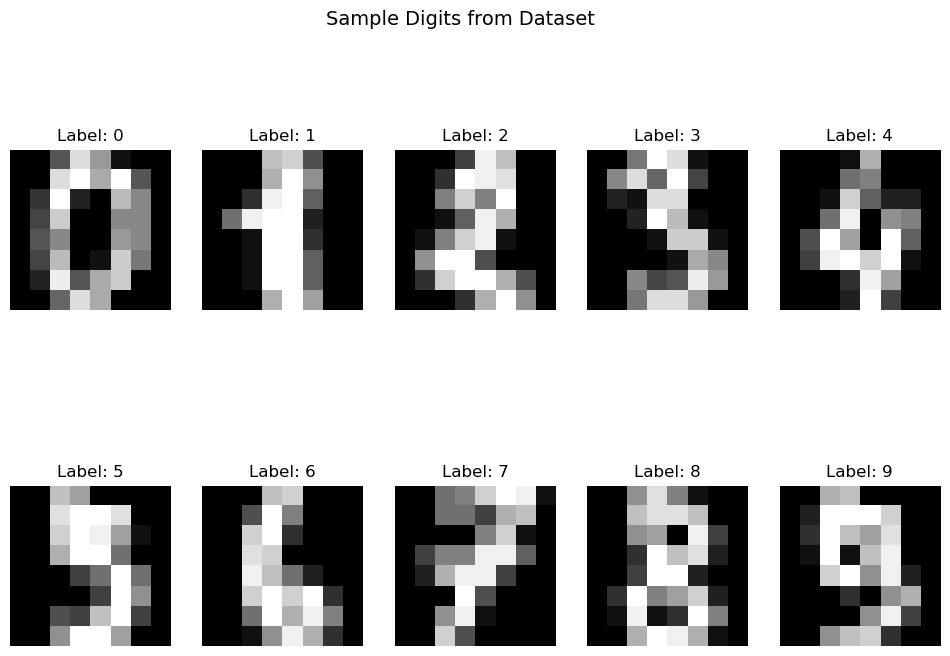

In [4]:
fig, axes = plt.subplots(2, 5, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i].reshape(8,8), cmap='gray')
    ax.set_title(f"Label: {y[i]}")
    ax.axis('off')
plt.suptitle("Sample Digits from Dataset", fontsize=14)
plt.show()

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

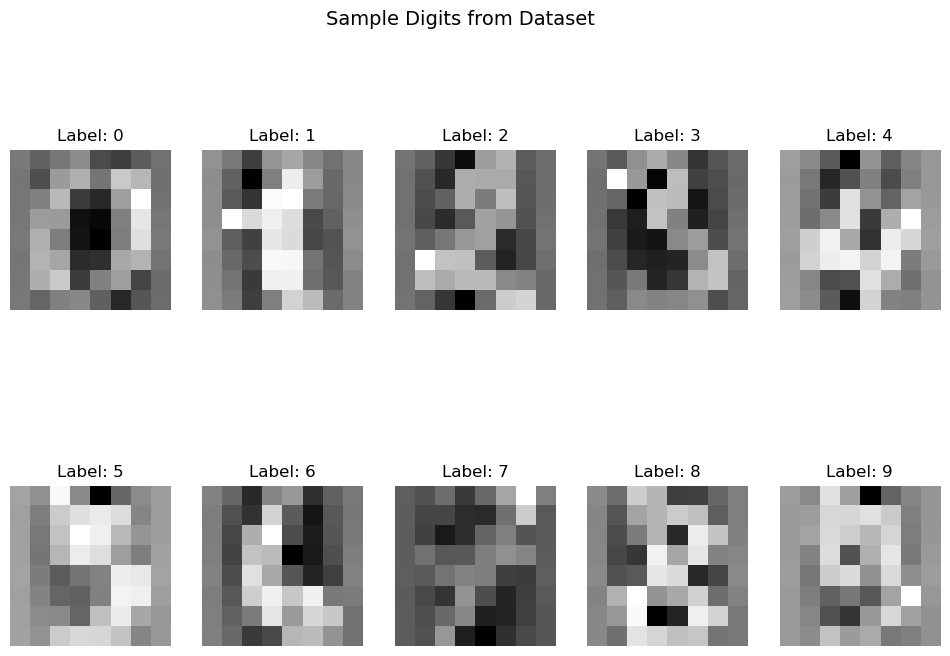

In [6]:
fig, axes = plt.subplots(2, 5, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_scaled[i].reshape(8,8), cmap='gray')
    ax.set_title(f"Label: {y[i]}")
    ax.axis('off')
plt.suptitle("Sample Digits from Dataset", fontsize=14)
plt.show()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# 2. PyTorch batchnorm + earlystopping

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

In [9]:
class TorchMLPBN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(64, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.relu1(self.bn1(self.fc1(x)))
        x = self.relu2(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [10]:
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.long)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

In [11]:
model_torch = TorchMLPBN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_torch.parameters(), lr=0.01)

In [12]:
torch_train_losses = []
torch_test_losses = []
torch_val_accuracies = []
patience = 5
best_acc = 0
trigger_times = 0

In [13]:
for epoch in range(100):
    model_torch.train()
    optimizer.zero_grad()
    y_logits = model_torch(X_train_torch)
    loss = criterion(y_logits, y_train_torch)
    loss.backward()
    optimizer.step()
    torch_train_losses.append(loss.item())

    model_torch.eval()
    with torch.no_grad():
        logits = model_torch(X_test_torch)
        preds = torch.argmax(logits, axis=1)
        test_loss = criterion(logits, y_test_torch)
        acc = (preds == y_test_torch).float().mean().item()
        torch_val_accuracies.append(acc)
        torch_test_losses.append(test_loss.item())

        if acc > best_acc:
            best_acc = acc
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f"Early stopped at epoch {epoch}")
                break

Early stopped at epoch 33


# 3. Tensorflow batchnorm + earlystopping

In [14]:
import tensorflow.keras as keras

In [15]:
import tensorflow as tf

In [16]:
class TFMLPBN(keras.Model):
    def __init__(self):
        super().__init__()
        self.fc1 = keras.layers.Dense(128)
        self.bn1 = keras.layers.BatchNormalization()
        self.relu1 = keras.layers.ReLU()
        self.fc2 = keras.layers.Dense(64)
        self.bn2 = keras.layers.BatchNormalization()
        self.relu2 = keras.layers.ReLU()
        self.fc3 = keras.layers.Dense(10)

    def call(self, inputs, training=False):
        x = self.relu1(self.bn1(self.fc1(inputs)))
        x = self.relu2(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [17]:
X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.int64)
X_test_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tf = tf.convert_to_tensor(y_test, dtype=tf.int64)

model_tf = TFMLPBN()
model_tf(tf.zeros((1, 64)))  # build
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [18]:
tf_train_losses = []
tf_val_accuracies = []
tf_test_losses = []
patience = 5
best_acc = 0
trigger_times = 0

In [19]:
for epoch in range(100):
    with tf.GradientTape() as tape:
        y_logits = model_tf(X_train_tf, training=True)
        loss = loss_fn(y_train_tf, y_logits)
    grads = tape.gradient(loss, model_tf.trainable_variables)
    optimizer.apply_gradients(zip(grads, model_tf.trainable_variables))
    tf_train_losses.append(loss.numpy())


    logits = model_tf(X_test_tf, training=False)
    preds = tf.argmax(logits, axis=1)
    test_loss = loss_fn(y_test_tf, logits)
    acc = tf.reduce_mean(tf.cast(preds == y_test_tf, tf.float32)).numpy()
    tf_val_accuracies.append(acc)
    tf_test_losses.append(test_loss.numpy())

    if acc > best_acc:
        best_acc = acc
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopped at epoch {epoch}")
            break

Early stopped at epoch 20


# 4. Plot loss

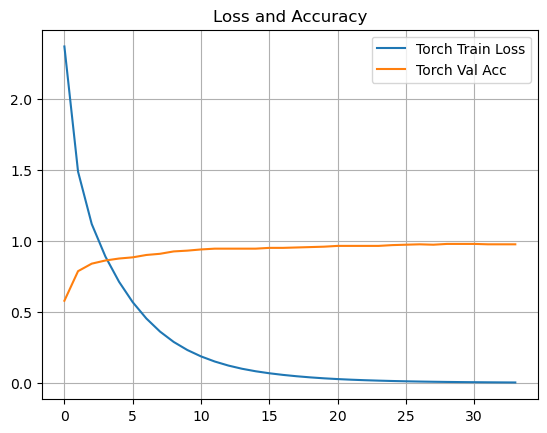

In [20]:
plt.plot(torch_train_losses, label="Torch Train Loss")
plt.plot(torch_val_accuracies, label="Torch Val Acc")
plt.legend()
plt.grid(True)
plt.title("Loss and Accuracy")
plt.show()

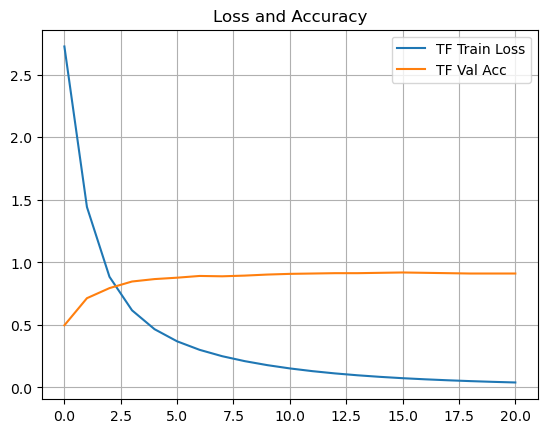

In [21]:
plt.plot(tf_train_losses, label="TF Train Loss")
plt.plot(tf_val_accuracies, label="TF Val Acc")
plt.legend()
plt.grid(True)
plt.title("Loss and Accuracy")
plt.show()

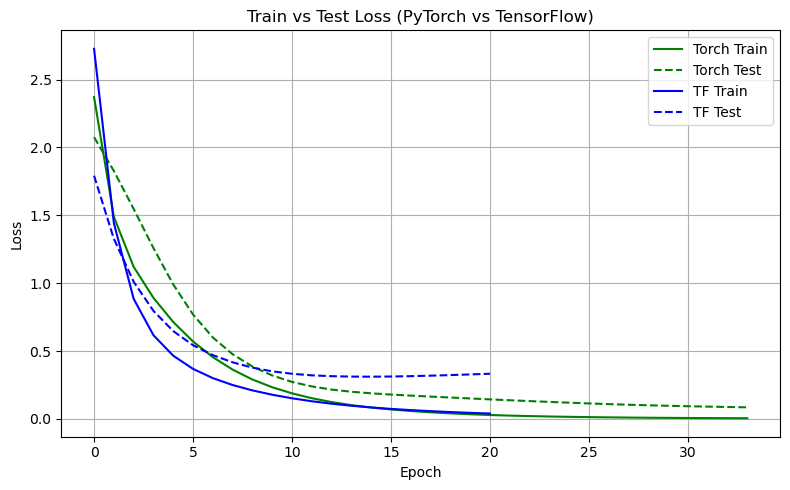

In [24]:
plt.figure(figsize=(8, 5))
# Torch
plt.plot(torch_train_losses, color="green", label='Torch Train')
plt.plot(torch_test_losses, linestyle='--', color="green", label='Torch Test')

# TF
plt.plot(tf_train_losses, color="blue", label='TF Train')
plt.plot(tf_test_losses, linestyle='--', color="blue", label='TF Test')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss (PyTorch vs TensorFlow)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()